In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
data = pd.read_csv("data.csv")

## Question 1
### a)
Looking briefly at the data, we can see a column total_items, which seems to indicate the total number of purchases made for a given order. If we have multiple items in an order, it makes sense then that the naively calculated average be much higher than the average item price. We double check this assumption below.

In [2]:
data[["order_amount", "total_items"]].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


As indicated above, the mentioned amount of $3145.13 is the simple mean of the order_amount column, and we can see that there are often more than one items in a given order. We also note the very large variance in the data in both order_amount and total_items. To deal with this, we have a few options to better evaluate the data: 1) use the median instead of the mean, 2) finding the average price of an item instead of an order 3) calculate the AOV with outliers removed.

##### Median Order Value
The median is better suited to this dataset given its large variance. As we can see below, it's a much more reasonable number. 

In [3]:
data["order_amount"].median()

284.0

##### Average Item Price
We calculate the average price of each item sold to be $357.92. Note that this measures something slightly different than the AOV. This is the average price of an item that sold from one of the 100 stores, while AOV is the average amount a customer spends at the 100 stores. 

In [4]:
data["order_amount"].mean() / data["total_items"].mean()

357.92152221412965

##### Removing Outliers
Seeing the histogram below, we can see that there is one store selling its item for a huge price. We can also see that while the majority of orders are for a reasonable number of items, there are 17 which are ordering 2000 items. If we remove those from our set we can calculate AOV using a mean and attain a more reasonable result.

<AxesSubplot:xlabel='shop_id', ylabel='item_amount'>

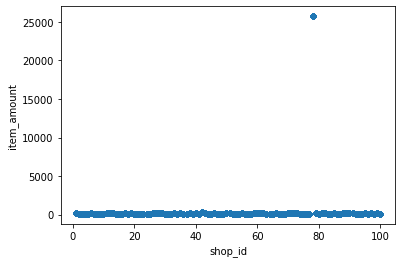

In [5]:
data["item_amount"] = data["order_amount"] / data["total_items"]
data.plot.scatter(x="shop_id", y="item_amount")

In [6]:
data["total_items"].value_counts()

2       1832
1       1830
3        941
4        293
5         77
2000      17
6          9
8          1
Name: total_items, dtype: int64

In [7]:
orders_no_outliers = data[(data["shop_id"] != 78) & (data["total_items"] < 10)]["order_amount"]
orders_no_outliers.describe()

count    4937.000000
mean      302.580514
std       160.804912
min        90.000000
25%       163.000000
50%       284.000000
75%       387.000000
max      1760.000000
Name: order_amount, dtype: float64

### b) & c)
I think the purpose of analyzing a metric like AOV is to be able to predict how the average, random consumer behaves in the shopify stores. It is unlikely that the average consumer orders 2000 shoes, or purchases shoes valued at $25k+. I would guess that these are either data errors, or represent things like wholesalers or a niche market. As such, I think it's appropriate to remove these outliers and analyze the remaining data. As shown above, the variance is at a much more reasonable level now, so we can use the mean. And we can see that the calculated AOV is closer to an expected value at around 302.

In [8]:
orders_no_outliers.mean()

302.58051448247926

## Question 2

### a)
How many orders were shipped by Speedy Express in total?
```
SELECT COUNT(*) 
FROM Orders 
WHERE ShipperID = 
	(SELECT ShipperID 
    FROM Shippers 
    WHERE ShipperName = "Speedy Express");

54
```
### b)
What is the last name of the employee with the most orders?
```
SELECT LastName 
FROM Employees 
WHERE EmployeeID = 
    (SELECT EmployeeID
    FROM 
        (SELECT EmployeeID, COUNT(*) as OrderCount
         FROM ORDERS
         GROUP BY EmployeeID)
    WHERE OrderCount = (SELECT Max(OrderCount)
                        FROM 
                          (SELECT EmployeeID, COUNT(*) as OrderCount
                          FROM ORDERS
                          GROUP BY EmployeeID)));
                          
Peacock
```
### c)
What product was ordered the most by customers in Germany?
```
SELECT ProductName
FROM Products a
LEFT JOIN 
(SELECT ProductID, COUNT(*) as ProdCount
FROM OrderDetails 
WHERE OrderID IN
	(SELECT OrderID 
	FROM Orders
	WHERE CustomerID IN
    	(SELECT CustomerID FROM Customers
		WHERE Country = 'Germany'))
GROUP BY ProductID) b
ON a.ProductID = b.ProductID
WHERE b.ProdCount = 
	(SELECT MAX(ProdCount)
    FROM 
    	(SELECT ProductID, COUNT(*) as ProdCount
        FROM OrderDetails 
        WHERE OrderID IN
            (SELECT OrderID 
            FROM Orders
            WHERE CustomerID IN
                (SELECT CustomerID FROM Customers
                WHERE Country = 'Germany'))
        GROUP BY ProductID))

Gorgonzola Telino
    
```